#### **Use Grid Search to Find the most Informative Peaks**

Import Libraries

In [83]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from scipy.signal import peak_widths, peak_prominences
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, cross_validate
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score
from Spectra_Preparation_Functions import *

Read the spectral data

In [84]:
#df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")
#df = pd.read_csv("../../data/exosomes.raw_spectrum_400-1800.csv")
#df = pd.read_csv("../../data/current_clean_spectrum.csv", index_col=0)
df = pd.read_csv("../../data/current_clean_spectrum.csv")

In [85]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,41.863303
1,201210-1-00,294,400.91116,201210-1,Normal,41.803843
2,201210-1-00,295,401.59454,201210-1,Normal,41.741884
3,201210-1-00,296,402.27789,201210-1,Normal,41.677722
4,201210-1-00,297,402.96127,201210-1,Normal,41.611654
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,12.378163
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,13.269937
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,14.199285
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,15.166531


#### **1 Sample Examples**

In [86]:
sample = df[df['SpecID'] == "210526-3-04"]
print(sample)

              SpecID   Seq  WaveNumber     SurID         Status  Absorbance
6206421  210526-3-04   293   400.22778  210526-3  Hyperglycemia   47.039364
6206422  210526-3-04   294   400.91116  210526-3  Hyperglycemia   47.251778
6206423  210526-3-04   295   401.59454  210526-3  Hyperglycemia   47.330543
6206424  210526-3-04   296   402.27789  210526-3  Hyperglycemia   47.284013
6206425  210526-3-04   297   402.96127  210526-3  Hyperglycemia   47.120545
...              ...   ...         ...       ...            ...         ...
6208465  210526-3-04  2337  1797.03870  210526-3  Hyperglycemia   17.612332
6208466  210526-3-04  2338  1797.72200  210526-3  Hyperglycemia   18.617765
6208467  210526-3-04  2339  1798.40550  210526-3  Hyperglycemia   19.620287
6208468  210526-3-04  2340  1799.08890  210526-3  Hyperglycemia   20.617020
6208469  210526-3-04  2341  1799.77220  210526-3  Hyperglycemia   21.605086

[2049 rows x 6 columns]


Find Peaks Within the spectrum.

In [87]:
#peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)
peaks, _ = find_peaks(x=sample['Absorbance'])

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

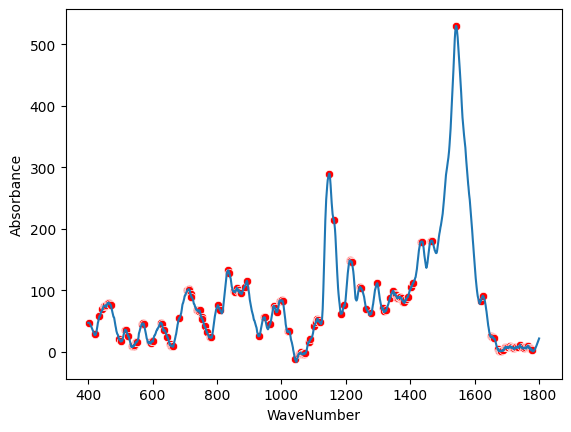

In [88]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[peaks], x="WaveNumber", y="Absorbance", color="red")

As you can see, it does not properly find the peaks, so we have to tune the peak finding parameters.

These parameters are based on Thomas Keogh's Search

In [89]:
tuned_peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

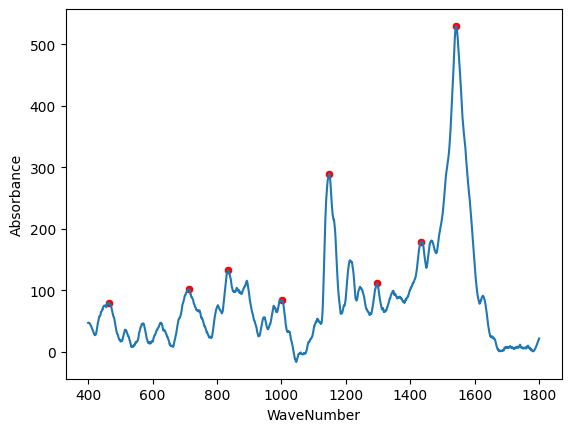

In [90]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[tuned_peaks], x="WaveNumber", y="Absorbance", color="red")

#### **Find the best Peak Finding Parameters**

Create a field for each wavelength.

Train an Extra Trees Classifier

In [91]:
def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = []
    for train_index, test_index in cv.split(X, y, groups):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the Extra Trees classifier
        et.fit(X_train, y_train)
        predictions = et.predict(X_test)
        
        # Evaluate the model
        score = accuracy_score(y_test, predictions)
        scores.append(score)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

#### **1. Using Peak Statistics**

In [92]:
backup = df

In [93]:
statuses = df[['SpecID', 'Status','SurID']].drop_duplicates()

This uses statistical properties of the peaks in each sample to be used as additional features.

In [148]:
peaks = []
widths = []
prominences = []

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    #peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42, width=6)
    peak_index, _ = find_peaks(x=group['Absorbance'], distance=10, width=1)


    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

/tmp/ipykernel_7246/272031481.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_7246/272031481.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [149]:
peaks_df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences
34,201210-1-00,327,423.46240,201210-1,Normal,42.023016,8.600727,2.549748
47,201210-1-00,340,432.34625,201210-1,Normal,40.318761,2.888985,1.970168
60,201210-1-00,353,441.23007,201210-1,Normal,41.740866,8.564034,3.886700
82,201210-1-00,375,456.26425,201210-1,Normal,48.589303,29.697436,10.744079
96,201210-1-00,389,465.83142,201210-1,Normal,47.996869,4.377311,2.888263
...,...,...,...,...,...,...,...,...
6228859,210526-3-49,2241,1731.43510,210526-3,Hyperglycemia,13.542362,3.624918,1.182615
6228872,210526-3-49,2254,1740.31880,210526-3,Hyperglycemia,10.321555,2.756891,0.475869
6228890,210526-3-49,2272,1752.61960,210526-3,Hyperglycemia,9.123648,2.781653,1.413251
6228909,210526-3-49,2291,1765.60360,210526-3,Hyperglycemia,8.372926,7.387193,1.444455


In [150]:
#sns.scatterplot(data=peaks_df, x="WaveNumber", y="Absorbance", hue='Status')

Standard Deviation of the Absorbances appears to have a positive affect on accuracy.

In [151]:
# Create a new DataFrame for the summary statistics
peak_stats = peaks_df.groupby('SpecID').agg({
    'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
    'PeakWidths': ['mean', 'std', 'max', 'min'],
    'PeakProminences': ['mean', 'std', 'max', 'min']
}).reset_index()

# Flatten the multi-level columns and customize the names
peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

In [152]:
# # Create a new DataFrame for the summary statistics
# peak_stats = peaks_df.groupby('SpecID').agg({
#     'PeakWidths': ['mean', 'std', 'max', 'min'],
#     'PeakProminences': ['mean', 'std', 'max', 'min']
# }).reset_index()

# # Flatten the multi-level columns and customize the names
# peak_stats.columns = ['SpecID',
#                       'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
#                       'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

Sometimes not every sample has a peak.

In [153]:
peak_stats.head()

,SpecID,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min
0,201210-1-00,47.697011,38.619883,59,173.397843,-7.558160,17.526858,32.103928,194.114304,1.009065,14.931027,34.610743,169.566634,0.129646
1,201210-1-01,53.442579,52.092788,53,188.679018,-5.154204,20.232244,33.058101,151.983867,1.022492,21.362867,47.064404,187.781984,0.152319
2,201210-1-02,119.554087,209.438463,46,1336.381183,-8.817219,16.977452,18.674036,67.855151,1.074776,63.597983,216.124140,1341.050057,0.265206
3,201210-1-03,195.519796,269.186601,38,987.344326,-49.907658,19.193429,21.526621,71.923318,1.014021,110.476588,265.316762,1000.595932,0.225276
4,201210-1-04,73.428476,60.194811,57,306.170893,-15.437870,18.315592,33.723261,183.353131,1.024586,21.425882,52.645245,317.970476,0.094372


In [154]:
peak_stats.shape

(3045, 14)

In [155]:
peak_stats = pd.merge(statuses, peak_stats, on='SpecID', how='left')
peak_stats = peak_stats.set_index('SpecID')
peak_stats = peak_stats.fillna(0)

In [156]:
peak_stats.shape

(2999, 15)

In [157]:
peak_stats.head()

,Status,SurID,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min
SpecID,,,,,,,,,,,,,,,
201210-1-00,Normal,201210-1,47.697011,38.619883,59,173.397843,-7.558160,17.526858,32.103928,194.114304,1.009065,14.931027,34.610743,169.566634,0.129646
201210-1-01,Normal,201210-1,53.442579,52.092788,53,188.679018,-5.154204,20.232244,33.058101,151.983867,1.022492,21.362867,47.064404,187.781984,0.152319
201210-1-02,Normal,201210-1,119.554087,209.438463,46,1336.381183,-8.817219,16.977452,18.674036,67.855151,1.074776,63.597983,216.124140,1341.050057,0.265206
201210-1-03,Normal,201210-1,195.519796,269.186601,38,987.344326,-49.907658,19.193429,21.526621,71.923318,1.014021,110.476588,265.316762,1000.595932,0.225276
201210-1-04,Normal,201210-1,73.428476,60.194811,57,306.170893,-15.437870,18.315592,33.723261,183.353131,1.024586,21.425882,52.645245,317.970476,0.094372


In [158]:
evaluate_extra_trees(peak_stats)

ExtraTreesClassifier Cross-Validation Accuracy: 0.3900 +/- 0.0859


> ##### **Combine these stats with the full spectra**

In [159]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,41.863303
1,201210-1-00,294,400.91116,201210-1,Normal,41.803843
2,201210-1-00,295,401.59454,201210-1,Normal,41.741884
3,201210-1-00,296,402.27789,201210-1,Normal,41.677722
4,201210-1-00,297,402.96127,201210-1,Normal,41.611654
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,12.378163
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,13.269937
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,14.199285
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,15.166531


In [160]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,41.863303,41.803843,41.741884,41.677722,41.611654,41.543974,41.474980,41.404968,41.334234,41.263073,...,6.280946,5.549559,4.745724,3.866578,2.909255,1.870891,0.748623,-0.460415,201210-1,Normal
201210-1-01,46.314608,47.323684,48.299209,49.241395,50.150457,51.026608,51.870063,52.681035,53.459738,54.206386,...,6.769011,7.280928,7.861246,8.512936,9.238972,10.042323,10.925962,11.892860,201210-1,Normal
201210-1-02,118.159018,114.686240,111.563911,108.777452,106.312282,104.153823,102.287493,100.698715,99.372907,98.295491,...,-4.633601,-4.557349,-4.439365,-4.278894,-4.075180,-3.827470,-3.535010,-3.197043,201210-1,Normal
201210-1-03,175.466997,174.846086,174.188020,173.498226,172.782129,172.045155,171.292728,170.530275,169.763222,168.996993,...,-10.801936,-10.349539,-9.864191,-9.347124,-8.799567,-8.222752,-7.617909,-6.986269,201210-1,Normal
201210-1-04,111.814973,106.629998,101.867380,97.512673,93.551430,89.969205,86.751551,83.884023,81.352173,79.141556,...,-11.689508,-11.752441,-11.789205,-11.799583,-11.783357,-11.740310,-11.670224,-11.572882,201210-1,Normal


In [161]:
evaluate_extra_trees(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.6123 +/- 0.1083


In [162]:
stats_and_spectrum = wavelength_df.merge(peak_stats.drop(columns=['SurID', 'Status']), on='SpecID')
stats_and_spectrum.columns = stats_and_spectrum.columns.astype(str)
stats_and_spectrum.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,41.863303,41.803843,41.741884,41.677722,41.611654,41.543974,41.474980,41.404968,41.334234,41.263073,...,173.397843,-7.558160,17.526858,32.103928,194.114304,1.009065,14.931027,34.610743,169.566634,0.129646
201210-1-01,46.314608,47.323684,48.299209,49.241395,50.150457,51.026608,51.870063,52.681035,53.459738,54.206386,...,188.679018,-5.154204,20.232244,33.058101,151.983867,1.022492,21.362867,47.064404,187.781984,0.152319
201210-1-02,118.159018,114.686240,111.563911,108.777452,106.312282,104.153823,102.287493,100.698715,99.372907,98.295491,...,1336.381183,-8.817219,16.977452,18.674036,67.855151,1.074776,63.597983,216.124140,1341.050057,0.265206
201210-1-03,175.466997,174.846086,174.188020,173.498226,172.782129,172.045155,171.292728,170.530275,169.763222,168.996993,...,987.344326,-49.907658,19.193429,21.526621,71.923318,1.014021,110.476588,265.316762,1000.595932,0.225276
201210-1-04,111.814973,106.629998,101.867380,97.512673,93.551430,89.969205,86.751551,83.884023,81.352173,79.141556,...,306.170893,-15.437870,18.315592,33.723261,183.353131,1.024586,21.425882,52.645245,317.970476,0.094372


In [163]:
evaluate_extra_trees(stats_and_spectrum)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5699 +/- 0.1095


#### **2. Creating a uniform Peak Featureset**

This aims to create a featureset using peaks within wavenumber intervals.

Assign Peaks to bins of a fixed wavelength interval.

In [164]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

In [165]:
# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))

/tmp/ipykernel_7246/3718610318.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))


In [166]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences,Bin
34,201210-1-00,327,423.46240,201210-1,Normal,42.023016,8.600727,2.549748,400-425
47,201210-1-00,340,432.34625,201210-1,Normal,40.318761,2.888985,1.970168,425-450
60,201210-1-00,353,441.23007,201210-1,Normal,41.740866,8.564034,3.886700,425-450
82,201210-1-00,375,456.26425,201210-1,Normal,48.589303,29.697436,10.744079,450-475
96,201210-1-00,389,465.83142,201210-1,Normal,47.996869,4.377311,2.888263,450-475


Set the bins as columns with the peak absrobances, widths and prominences as the values.
If no peaks appear in a bin the value is set to 0.
If multiple peaks appear their properties are aggregated.

In [167]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
peak_bins = peaks_df.pivot_table(index='SpecID', columns='Bin', values=['Absorbance', 'PeakWidths', 'PeakProminences'], aggfunc='max')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = peaks_df[['SpecID', 'Status', 'SurID']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with 0
peak_bins.fillna(0, inplace=True)

In [168]:
peak_bins.head()

,Absorbance_1000-1025,Absorbance_1025-1050,Absorbance_1050-1075,Absorbance_1075-1100,Absorbance_1100-1125,Absorbance_1125-1150,Absorbance_1150-1175,Absorbance_1175-1200,Absorbance_1200-1225,Absorbance_1225-1250,...,PeakWidths_800-825,PeakWidths_825-850,PeakWidths_850-875,PeakWidths_875-900,PeakWidths_900-925,PeakWidths_925-950,PeakWidths_950-975,PeakWidths_975-1000,Status,SurID
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,105.303597,72.002940,71.542389,0.000000,25.662801,36.588736,29.066064,10.317678,4.591960,46.437130,...,16.714187,0.000000,15.573611,119.577556,0.000000,2.131577,0.000000,0.000000,Normal,201210-1
201210-1-01,104.660172,0.000000,69.513134,0.000000,0.000000,38.102230,38.105273,22.970621,-0.179265,8.481125,...,1.155223,0.000000,13.112880,0.000000,143.050278,17.800870,0.000000,0.000000,Normal,201210-1
201210-1-02,177.738344,198.517470,0.000000,0.000000,0.000000,84.362304,0.000000,8.866825,24.391940,26.759195,...,3.840262,0.000000,4.381959,0.000000,35.976770,0.000000,16.240938,0.000000,Normal,201210-1
201210-1-03,0.000000,0.000000,235.350860,0.000000,0.000000,0.000000,637.224178,0.000000,0.000000,84.124555,...,0.000000,2.934952,0.000000,0.000000,70.641586,0.000000,57.105582,1.527180,Normal,201210-1
201210-1-04,98.087538,51.483016,47.404555,18.428525,13.959103,44.367539,54.629324,76.368244,27.400714,17.953839,...,0.000000,0.000000,135.588036,6.032436,10.272983,2.537245,0.000000,1.830816,Normal,201210-1


In [169]:
evaluate_extra_trees(peak_bins)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5526 +/- 0.1171


In [170]:
bins_and_spectrum = wavelength_df.merge(peak_stats.drop(columns=['SurID', 'Status']), on='SpecID')
bins_and_spectrum.columns = stats_and_spectrum.columns.astype(str)
bins_and_spectrum.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,41.863303,41.803843,41.741884,41.677722,41.611654,41.543974,41.474980,41.404968,41.334234,41.263073,...,173.397843,-7.558160,17.526858,32.103928,194.114304,1.009065,14.931027,34.610743,169.566634,0.129646
201210-1-01,46.314608,47.323684,48.299209,49.241395,50.150457,51.026608,51.870063,52.681035,53.459738,54.206386,...,188.679018,-5.154204,20.232244,33.058101,151.983867,1.022492,21.362867,47.064404,187.781984,0.152319
201210-1-02,118.159018,114.686240,111.563911,108.777452,106.312282,104.153823,102.287493,100.698715,99.372907,98.295491,...,1336.381183,-8.817219,16.977452,18.674036,67.855151,1.074776,63.597983,216.124140,1341.050057,0.265206
201210-1-03,175.466997,174.846086,174.188020,173.498226,172.782129,172.045155,171.292728,170.530275,169.763222,168.996993,...,987.344326,-49.907658,19.193429,21.526621,71.923318,1.014021,110.476588,265.316762,1000.595932,0.225276
201210-1-04,111.814973,106.629998,101.867380,97.512673,93.551430,89.969205,86.751551,83.884023,81.352173,79.141556,...,306.170893,-15.437870,18.315592,33.723261,183.353131,1.024586,21.425882,52.645245,317.970476,0.094372


In [171]:
evaluate_extra_trees(bins_and_spectrum)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5699 +/- 0.1095
